# HOOMD-blue Langevin dynamics simulation of colloidal system 

**Author**: _Ye Nguyen Edalgo_

**Description:**
    1. Running Langevin dynamics 
    2. colloidal system of 8000 nanoparticles following LJ model 
    3. adding feature of magnetic dipole-dipole interaction between NPs
    
**Reference:**
1. Andreu JS, Camacho J, Faraudo J.   Aggregation of superparamagnetic col-
loids in magnetic fields:  The quest for the equilibrium state.   Soft Matter.
2011;7(6):2336–2339 [(link)](https://drive.google.com/open?id=1cA7Hk4Fqd04B9QodT0V7F7LH0apfNCsE)
2. Dr. Schiller lecture on Langevin dynamics [(link)](https://nbviewer.jupyter.org/github/yennguyenedalgo/MSE-8900-Multiscale-Modeling/blob/master/Lecture-3-2_Langevin-Dynamics.ipynb)

In [3]:
"""Initialization"""
import os
from math import *
import numpy as np
from matplotlib import pyplot as plt
import hoomd
import hoomd.md
import hoomd.deprecated
hoomd.context.initialize("");

HOOMD-blue 2.3.1 DOUBLE HPMC_MIXED SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


**Parameters**

Parameter values are obtained from LAMMPS simulation of magnetic colloids by Faraudo_2011_SI [(link)](https://pubs.rsc.org/en/content/articlelanding/2011/sm/c0sm01424a#!divAbstract)

In [4]:
"""Output filename (User defined Var)"""
change_seed = 99
type = 'TestDiffusion'
Equil_fname = 'Data/trajectory_Equil_5.gsd'

In [5]:
"""Reference value (User defined Var)"""
mass            = 5.24e-19                                  #kg/particle
LJ_sigma        = 100                                       #nm
LJ_epsilon      = 1.3e-20                                   #J or kg m2 s-2
time_scale      = LJ_sigma*(mass/LJ_epsilon)**(1/2)*1e-9    #sec
kB              = 1.38064852e-23                            #kg m2 s-2 K-1
mag_const       = 4*pi*1e-7                                 #T m A-1

"""Real Units"""
par_ls          = 20                   #particle
box_length      = 9.3e3                #nm
NP_diameter     = 100                  #nm
r_cut_LJ        = NP_diameter          #nm
r_cut_dd        = 1000                 #nm
time_step       = 1e-9                 #s
viscosity       = 8.5251e-4            #N m-2 s-1 #NIST at water density=1000g/L
damp            = mass / (3*pi * viscosity * NP_diameter*1e-9) #s
drag_coeff      = mass / damp
T               = 300                  #K
dipole_moment   = 1.44e-17             #J/T
sim_time        = 1                    #s
total_step      = 1e9                  #step
log_period      = 0.51e-3              #s
log_period_step = 5e5                  #step

"""Normalized"""
mass_r          = 1
charge_r        = 0
LJ_sigma_r      = 1
LJ_epsilon_r    = 1
mag_const_r     = 1
box_length_r    = box_length / LJ_sigma
NP_diameter_r   = NP_diameter / LJ_sigma
r_cut_LJ_r      = r_cut_LJ / LJ_sigma
r_cut_dd_r      = r_cut_dd / LJ_sigma
time_step_r     = time_step / time_scale
damp_r          = damp / time_scale
drag_coeff_r    = mass_r / damp_r
T_r             = T * kB / LJ_epsilon
dipole_moment_r = dipole_moment / (4*pi / mag_const * LJ_epsilon * LJ_sigma**3)**(1/2)

print("mass: "+str(mass)+" kg/particle",
      "sigma: "+str(LJ_sigma)+" nm",
      "epsilon: "+str(LJ_epsilon)+" J",
      "box_length: "+str(box_length)+" nm",
      "r_cut_LJ: "+str(r_cut_LJ)+" nm",
      "r_cut_dd: "+str(r_cut_dd)+" nm",
      "time_step: "+str(time_step)+" s",
      "damp: "+str(damp)+" s",
      "drag: "+str(drag_coeff)+" kg/s",
      "temperature: "+str(T)+" K",
      "magnetic dipole moment: "+ str(dipole_moment_r),
      "sim_time: "+str(total_step * time_step)+" sec",
      "total step: "+str(total_step)+" steps",
      "total frames: "+str(total_step/log_period_step)+" steps",
      sep="\n")

"""Concentration, volume fraction, and diffusion Check"""
sys_vol         = box_length**3*1e-24                       #liter
par_vol         = 4/3*pi*(NP_diameter/2)**3*1e-24           #liter
concentration   = mass*par_ls**3*1e3/sys_vol                #g/L
vol_fraction    = format(par_vol*par_ls**3/sys_vol, 'e')
diffusion_coeff = kB*T / (3*pi*viscosity*NP_diameter*1e-9)
print("concentration is "+str(concentration)+" g/L")
print("volume fraction is "+str(vol_fraction))
print("D_theory is "+str(diffusion_coeff)+" m2/s")

mass: 5.24e-19 kg/particle
sigma: 100 nm
epsilon: 1.3e-20 J
box_length: 9300.0 nm
r_cut_LJ: 100 nm
r_cut_dd: 1000 nm
time_step: 1e-09 s
damp: 6.521697902284872e-10 s
drag: 8.034717459335505e-10 kg/s
temperature: 300 K
magnetic dipole moment: 3.99384141282165e-14
sim_time: 1.0 sec
total step: 1000000000.0 steps
total frames: 2000.0 steps
concentration is 5.211616235079696 g/L
volume fraction is 5.207626e-03
D_theory is 5.155060624051553e-12 m2/s


In [6]:
"""System preparation"""
uc = hoomd.lattice.unitcell(N = 1,
                        a1 = [box_length_r, 0, 0],
                        a2 = [0, box_length_r, 0], 
                        a3 = [0, 0, box_length_r], 
                        dimensions = 3, 
                        mass = [mass_r], 
                        diameter = [NP_diameter_r])
system = hoomd.init.create_lattice(uc, n=par_ls)

neighbor_ls = hoomd.md.nlist.tree();

notice(2): Group "all" created containing 8000 particles
-----
You are using tree neighbor lists. Please cite the following:
* M P Howard, J A Anderson, A Nikoubashman, S C Glotzer, and A Z
  Panagiotopoulos. "Efficient neighbor list calculation for molecular simulation
  of colloidal systems using graphics processing units", Computer Physics
  Communications 203 (2016) 45--52
-----


**Brownian Dynamics:**

Notice that $\frac{m}{\gamma}<<\delta t$ indicating that the system is overdamped. Hence the overdamped Langevin equation, also called the Brownian dynamics, is considered (Source: [link](https://hoomd-blue.readthedocs.io/en/stable/module-md-integrate.html#hoomd.md.integrate.brownian)):

\begin{equation}
    \frac{d\vec{x}}{dt} = \frac{\vec{F}_C + \vec{F}_R}{\gamma}
\end{equation}

where $m$ is the mass of one colloidal particle, $\gamma$ is the drag coefficient from the implicit solvent, $\vec{F}_C$ and $\vec{F}_R$ are the interaction forces within colloids and the random collision forces between solvent molecules and colloids, respectively.

In [7]:
"""Integrator"""

hoomd.md.integrate.mode_standard(dt=time_step_r, aniso=None);
all = hoomd.group.all();
integrator=hoomd.md.integrate.brownian(group=all, kT=T_r, seed=change_seed)
integrator.set_gamma('A', gamma=drag_coeff_r)

notice(2): integrate.langevin/bd is using specified gamma values


In [ ]:
"""Output""" 

hoomd.analyze.log(filename='Data/log-output_'+type+'.log',
                   quantities=['kinetic_energy', 'temperature'],
                   period=log_period_step,
                   overwrite=True);

hoomd.dump.gsd('Data/trajectory_'+type+'.gsd', period=log_period_step, group=all, overwrite=True);

hoomd.deprecated.analyze.msd(filename='Data/msd_'+type+'.log',
                  groups=[all],
                  period=log_period_step,
                  overwrite=True)

In [ ]:
hoomd.run(total_step)

**Calculate diffusion coefficient**

Diffusion coefficient obtained from the simulation trajectory ($D_{sim}$) is evaluated as:

\begin{equation}
     D_{sim} = \frac{\langle r^2 \rangle}{6t}
\end{equation}

$D_{sim}$ is compared with the diffusion coefficient obtained from theory $D_{theory}$ given as:

\begin{equation}
    D_{theory} = \frac{k_BT}{3\pi\eta d_p}
\label{D_theory}
\end{equation}

where $\langle r^2 \rangle$ is the mean square displacement (msd) obtained directly from hoomd outputs (Also, codes to calculate MSD from hoomd trajectory outputs are self-written [here](https://nbviewer.jupyter.org/github/yennguyenedalgo/JupyterNotebookProject/blob/master/msd_gsd.ipynb)) , $k_B T$ is the Boltzmann temperature, $\eta$ is the solvent viscosity, and $d_p$ is the diameter of the colloidal particle.

**Note:** When calculating diffusion coefficient, the purely diffusive motion is obtained in the absence of colloidal interactions ($F_C$ = 0). Hence implementation of LJ interaction is turned off.

LinregressResult(slope=5.2653730545653725e-12, intercept=-1.2691100338472823e-15, rvalue=0.9999710577959732, pvalue=0.0, stderr=1.2668456807052682e-16)
D_sim = 5.247489930000001e-13 m2/s
D_sim_2: 5.2653730545653725e-12
D_theory is 5.155060624051553e-12 m2/s


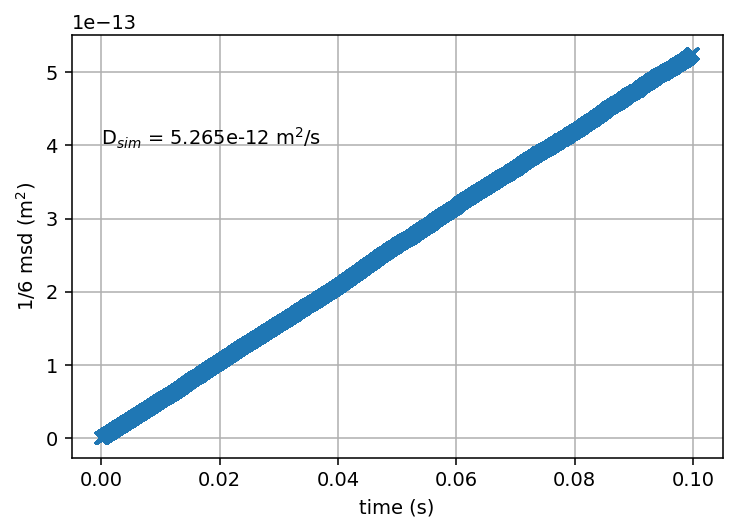

In [8]:
"""Plotting msd vs. time"""
import numpy as np 
from matplotlib import pyplot as plt

msd = np.genfromtxt(fname='Data/msd_'+type+'.log', skip_header=True);

x = msd[:,0] * time_step
y = msd[:,1] * (LJ_sigma*1e-9)**2 / 6

from scipy.stats import linregress
print(linregress(x,y)) #x and y are arrays or lists.   
slope, intercept, r_value, p_value, std_err = linregress(x, y)

D_sim = msd[-1,1] * (LJ_sigma*1e-9)**2 / sim_time / 6 
D_sim_2 = slope 
print('D_sim = '+str(D_sim)+' m2/s')
print("D_sim_2: "+str(D_sim_2))
print("D_theory is "+str(diffusion_coeff)+" m2/s")

plt.figure(figsize=None, dpi=140);
plt.plot(x, y, 'x');
plt.xlabel('time (s)');
plt.ylabel('$1/6$ msd (m$^2$)');
plt.text(0.0, 4e-13, 'D$_{sim}$ = '+str(format(D_sim_2,'.3e'))+' m$^2/$s')
plt.grid(True)
plt.savefig('Figures/msd_'+type+'.pdf')

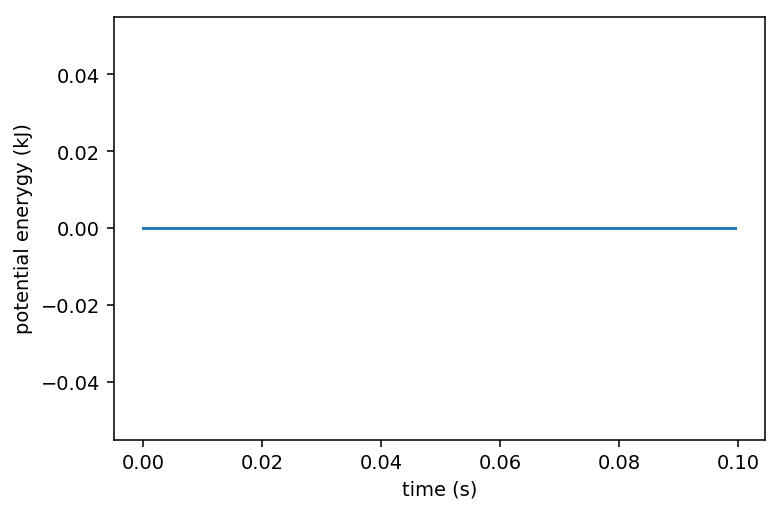

In [9]:
data = np.genfromtxt(fname='Data/log-output_'+type+'.log', skip_header=True);

plt.figure(figsize=None, dpi=140);
plt.plot(data[:,0]*time_step, data[:,1]*LJ_epsilon*1e-3);
plt.xlabel('time (s)');
plt.ylabel('potential enerygy (kJ)');
plt.savefig('Figures/PotentialEnergy_'+type+'.pdf')

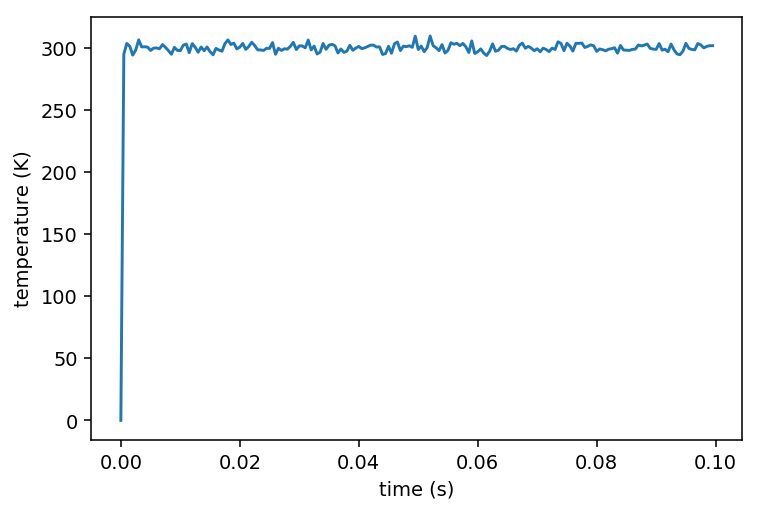

In [10]:
plt.figure(figsize=None, dpi=140);
plt.plot(data[:,0]*time_step, data[:,2]*LJ_epsilon/kB);
plt.xlabel('time (s)');
plt.ylabel('temperature (K)');
plt.savefig('Figures/Temperature_'+type+'.pdf')

In [ ]:
"""Lennard-Jones Potential"""
LJ = hoomd.md.pair.lj(r_cut=r_cut_LJ_r, nlist=neighbor_ls);
LJ.pair_coeff.set('A', 'A', epsilon=LJ_epsilon_r, sigma=LJ_sigma_r);

"""Dipole-Dipole Potential: SWITCH ON After system is equilibrated""" 
DD = hoomd.md.pair.dipole(r_cut=r_cut_dd_r, nlist=neighbor_ls)
DD.pair_coeff.set('A', 'A', mu=dipole_moment_r, A=1, kappa=0.0)

In [ ]:
"""Visualization"""
#import ex_render
#ex_render.display_movie(ex_render.render_sphere_frame, 'Data/trajectory_'+type+'.gsd');